# Introduction
Company XYZ sells a software for $39. Since revenue has been ﬂat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue.

In the experiment, 66% of the users have seen the old price (\$39), while a random sample of 33% of users a higher price (\$59).

The test has been running for some time and the VP of Product is interested in
1. Understanding how it went and whether it would make sense to increase the price for all the users.
2. Actionable insights that might increase conversion rate. What are your main ﬁndings looking at the data?
3. [Bonus] The VP of Product feels that the test has been running for too long and he should have been able to get statistically signiﬁcant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.

As always, you should focus on **user segmentation** and provide insights about segments who behave diﬀerently as well as any other insights you might ﬁnd.



# Data Loading and EDA

Env setting

In [1]:
# Print every output from a specific cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Change to the current location (ref: https://webapps.stackexchange.com/questions/170886/copy-the-path-of-a-file-in-google-drive)
import os
os.chdir('/content/drive/MyDrive/1 - Study Hard/Softwares and Coding/Python_ML/Dataset')
!pwd

/content/drive/MyDrive/1 - Study Hard/Softwares and Coding/Python_ML/Dataset


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind
%matplotlib inline

In [5]:
testfile = 'test_results.csv'
userfile = 'user_table3.csv'

test_df = pd.read_csv(testfile)
user_df = pd.read_csv(userfile)

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           316800 non-null  int64 
 1   timestamp         316800 non-null  object
 2   source            316800 non-null  object
 3   device            316800 non-null  object
 4   operative_system  316800 non-null  object
 5   test              316800 non-null  int64 
 6   price             316800 non-null  int64 
 7   converted         316800 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


In [8]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  275616 non-null  int64  
 1   city     275616 non-null  object 
 2   country  275616 non-null  object 
 3   lat      275616 non-null  float64
 4   long     275616 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


In [9]:
test_df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [10]:
user_df.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


## Check Data Shape, Type, Missing, Duplicates and Error-Codings


Join the two tables

In [7]:
data = pd.merge(test_df, user_df, on = 'user_id', how = 'left')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           316800 non-null  int64  
 1   timestamp         316800 non-null  object 
 2   source            316800 non-null  object 
 3   device            316800 non-null  object 
 4   operative_system  316800 non-null  object 
 5   test              316800 non-null  int64  
 6   price             316800 non-null  int64  
 7   converted         316800 non-null  int64  
 8   city              275616 non-null  object 
 9   country           275616 non-null  object 
 10  lat               275616 non-null  float64
 11  long              275616 non-null  float64
dtypes: float64(2), int64(4), object(6)
memory usage: 29.0+ MB


Missing data exist for city, country, lat, and long. But they will only impact the analysis, not the measurement.

In [116]:
# Check feature unique values
data.nunique(axis=0)

,0
user_id,316800
timestamp,140931
source,12
device,2
operative_system,6
test,2
price,2
converted,2
city,923
country,1


country only has one value. Doesn't provide any information. Will remove it from analysis.

In [117]:
data[['price', 'test']].value_counts()

price  test
39     0       202517
59     1       113918
       0          210
39     1          155
Name: count, dtype: int64

The price and test group should have a 1:1 mapping. But there are 155 samples with 'price' = \$39, but are wrongly coded in testing group, and 210 samples with 'price' = \$59, but are wrongly coded in control group.

Since they only take a small percentage of the entire data, we will remove these data points from the analysis.

In [8]:
data = data[((data['test'] == 1) & (data['price'] == 59)) | ((data['test'] == 0) & (data['price'] == 39))]

In [119]:
data[['price', 'test']].value_counts()

,,count
price,test,
39,0,202517
59,1,113918


In [120]:
data.duplicated().sum() # No duplicated rows exist

0

In [9]:
# The timestamp column contains invalid entries like '2015-04-24 12:60:46'. We will strip the time part and only keep the date info, which is enough for the analysis.
data['date'] = data['timestamp'].astype('str').str.slice(0, 10)

In [10]:
id_var = 'user_id'
date_var = 'date'
exclude_var = ['timestamp', id_var, 'country', date_var]
num_vars = list(data.iloc[:,~data.columns.isin(exclude_var)].select_dtypes(exclude = 'object').columns)
cat_vars = list(data.iloc[:,~data.columns.isin(exclude_var)].select_dtypes(include = 'object').columns)

In [11]:
num_vars
cat_vars

['test', 'price', 'converted', 'lat', 'long']

['source', 'device', 'operative_system', 'city']

## Numerical Vars Analysis
The following aspects of the data are studied in this section:
* Numerical feature densities
* Numerical features' pairwise relationships: scatter plot

In [126]:
data[num_vars].describe()

,test,price,converted,lat,long
count,316435.000000,316435.000000,316435.000000,275294.000000,275294.000000
mean,0.360004,46.200088,0.018336,37.112004,-93.981225
std,0.480002,9.600041,0.134162,5.209756,18.086916
min,0.000000,39.000000,0.000000,19.700000,-157.800000
25%,0.000000,39.000000,0.000000,33.660000,-112.200000
50%,0.000000,39.000000,0.000000,37.740000,-88.930000
75%,1.000000,59.000000,0.000000,40.700000,-78.910000
max,1.000000,59.000000,1.000000,61.180000,30.310000


Findings:
* Test data: 36%. Control data: 64%
* Overall conversion rate = 1.8%

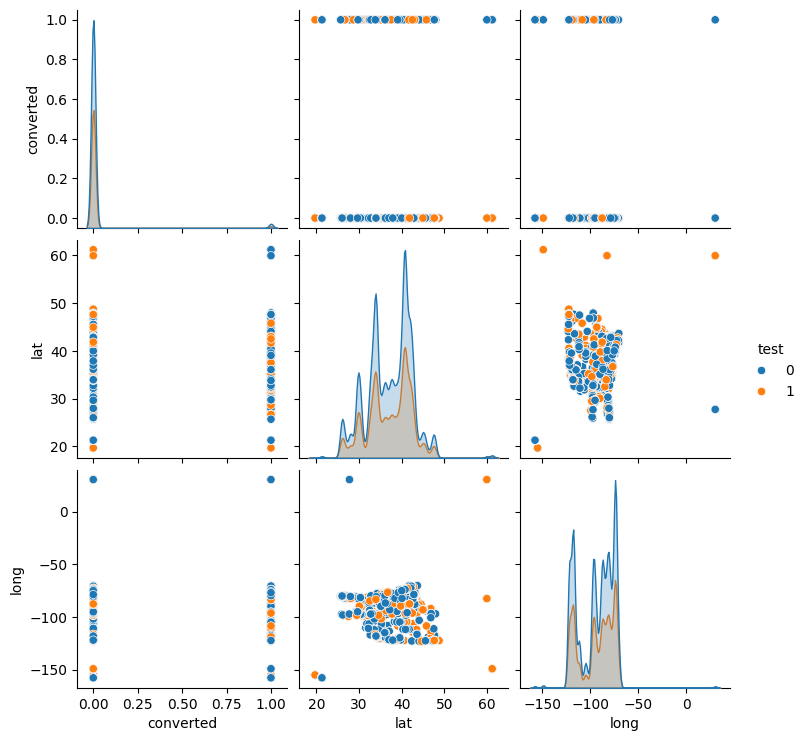

In [127]:
sns.pairplot(data, vars = ['converted',	'lat',	'long'], hue = 'test');

* Based on the density plots, we can see that the control and test groups are balanced well across the three numerical variables. This validates that the experiment is randomized.
* There appear to be some outliers based on the lat v.s.long scatter plot. Let's investigate them.

In [61]:
data[(data['lat'] > 55 ) | (data['long'] > 0) ][['lat', 'long', 'city']].value_counts()

lat    long     city            
61.18  -149.19  Anchorage           522
59.93  -82.64   Saint Petersburg    192
        30.31   Saint Petersburg    192
27.76   30.31   Saint Petersburg    145
Name: count, dtype: int64

In [62]:
data[data['city'] == 'Saint Petersburg'][['lat', 'long']].value_counts()

lat    long  
59.93  -82.64    192
        30.31    192
27.76  -82.64    176
        30.31    145
Name: count, dtype: int64

In [66]:
# For city Saint Petersburg, the lat long should be 59.9311° N, 30.3609° E. And for lat = 59.93, both long values have counts = 192, seems to be duplications. Let's find out.
tmp = data[(data['city'] == 'Saint Petersburg') & (data['lat'] == 59.93)]
tmp.loc[:, ~tmp.columns.isin(['lat', 'long'])].shape


(384, 10)

In [69]:
tmp.loc[:, ~tmp.columns.isin(['lat', 'long'])].duplicated().sum()

0

There is actually no duplicate. Due to the time limit, I will stop here and leave this for furture work.

In [63]:
data[data['city'] == 'Anchorage'][['lat', 'long']].value_counts()

,,count
lat,long,
61.18,-149.19,522


## Categorical Vars Analysis
In this section, categorical variables will be studied in terms of their frequency distributions by test variant


In [75]:
for c in cat_vars:
  data[c].value_counts(normalize = True)
  print('----------------')

,proportion
source,
direct_traffic,0.190494
ads-google,0.187469
ads_facebook,0.168580
ads_other,0.094282
seo-google,0.073148
ads-bing,0.072182
seo_facebook,0.066930
friend_referral,0.065348
seo-other,0.029225


----------------


,proportion
device,
mobile,0.588606
web,0.411394


----------------


,proportion
operative_system,
windows,0.318729
iOS,0.301331
android,0.236552
mac,0.079193
other,0.051142
linux,0.013052


----------------


,proportion
city,
New York,0.093404
Chicago,0.025962
Houston,0.024325
San Antonio,0.016818
Los Angeles,0.015025
San Jose,0.012164
Indianapolis,0.011674
Jacksonville,0.010545
Philadelphia,0.009213


----------------


In [128]:
cat_vars

['source', 'device', 'operative_system', 'city']

In [129]:
for c in cat_vars:
  data[c].nunique()

12

2

6

923

There are too many levels of city, which will make the graph messy. So, we will skip city for plotting.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'ads_facebook'),
  Text(1, 0, 'seo-google'),
  Text(2, 0, 'ads-bing'),
  Text(3, 0, 'direct_traffic'),
  Text(4, 0, 'ads-google'),
  Text(5, 0, 'seo_facebook'),
  Text(6, 0, 'friend_referral'),
  Text(7, 0, 'ads_other'),
  Text(8, 0, 'ads-yahoo'),
  Text(9, 0, 'seo-yahoo'),
  Text(10, 0, 'seo-bing'),
  Text(11, 0, 'seo-other')])

([0, 1], [Text(0, 0, 'mobile'), Text(1, 0, 'web')])

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'iOS'),
  Text(1, 0, 'android'),
  Text(2, 0, 'mac'),
  Text(3, 0, 'windows'),
  Text(4, 0, 'other'),
  Text(5, 0, 'linux')])

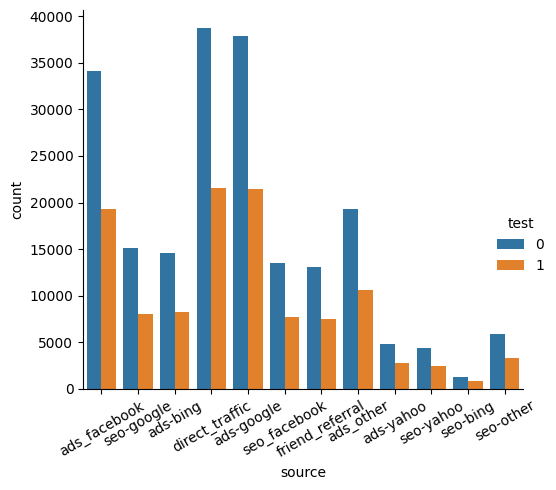

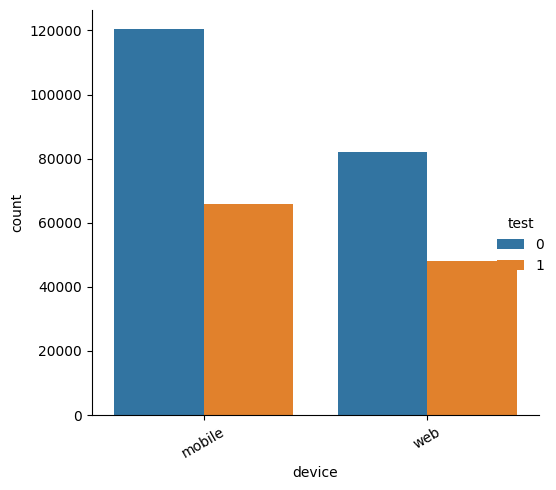

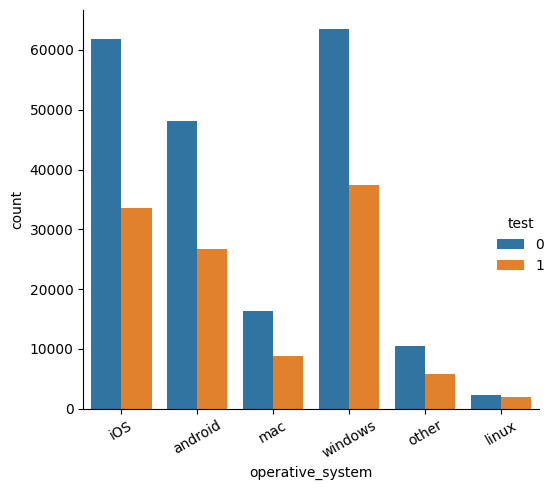

In [135]:
for c in cat_vars[:3]:
  sns.catplot(
    x=c,       # x variable name
    hue="test",  # group variable name
    data=data,     # dataframe to plot
    kind="count"
  )
  plt.xticks(rotation=30)
  plt.tight_layout();

We can see that the control and treatment groups are relatively balanced (~2:1) across user segments by categorical variables. No significant imbalance identified.

## Time Series Analysis

In [38]:
import matplotlib.ticker as ticker

In [21]:
data_ts = data.groupby(['test','date'], as_index = False)['revenue'].mean()
data_ts['date'] = pd.to_datetime(data_ts['date']).dt.date

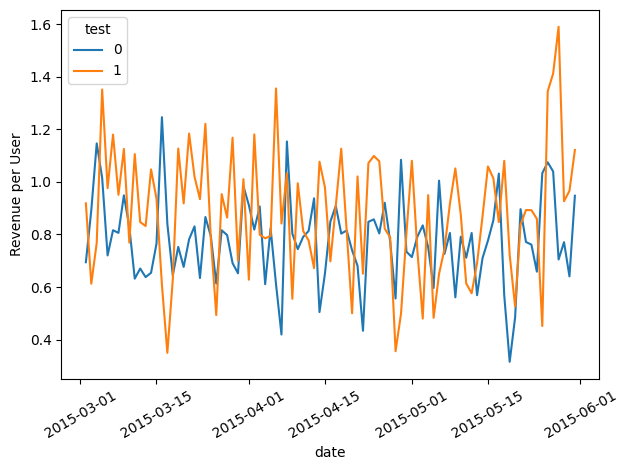

In [44]:
plot = sns.lineplot(data = data_ts, x = 'date', y = 'revenue', hue = 'test')
plt.ylabel("Revenue per User")
# plot.xaxis.set_major_locator(ticker.LinearLocator(10))  # only show 10 x-axis ticks, or convert 'date' to datatime type
plt.xticks(rotation=30)
plt.tight_layout()
plt.show();

In [46]:
data_ts[data_ts['revenue']>1.4]

,test,date,revenue
177,1,2015-05-27,1.413174
178,1,2015-05-28,1.591286


We can see that overall the revenue-per-user of the treatment and control groups are stable, and the treatment group stays at a higher level than the control group. However, there is a spike in the treatment group on 5/27/2015 and 5/28/2015. 5/25/2015 was the Memorial Day, and this might be the reason. We need to investigate further. Due to the time limit and lack of information, we will keep these days for now, and move on to the test measurement.

# AB Testing on Revenue

In this section, we will answer Q1 and Q3, and also analyze by user segments.
* Q1. Understanding how it went and whether it would make sense to increase the price for all the users.
* Q3. [Bonus] The VP of Product feels that the test has been running for too long and he should have been able to get statistically signiﬁcant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.

Based on the law of demand, we can tell that the conversion rate (product purchase rate) will decrease as price increases. The result below supports the above argument.

Therefore, for this pricing test, we will define the measurement metric as **revenue-per-user**. Since we don't have the purchase quantity information, we will assume 'converted' = 1 means quantity = 1 and 'converted' == 0 means means quantity = 0.


In [113]:
data.groupby('test')['converted'].mean()

,converted
test,
0,0.019904
1,0.015555


In [13]:
data['revenue'] = data['price']*data['converted']

Now let's have a peek into the revenue-per-user of the test and control groups.

In [14]:
data.groupby('test')['revenue'].mean()

,revenue
test,
0,0.776083
1,0.917748


We can see that the test group yields a higher revenue-per-user than the control group. Below, we will
* conduct statitical test to see if this is significant
* conduct sample size calculation to see if we have enough sample to conclude the test.

In [176]:
# We will conduct 2-sample t-test on the revenue-per-user.

class Ttest:
  def __init__(self, equal_var = True, alternative = 'greater'):
    self.equal_var = equal_var
    self.alternative = alternative

  def sample_var(self, x):
    '''
    # since sample size is large, will just use the population variance formula
    '''
    ss = np.mean(x**2) - (np.mean(x))**2
    return ss

  def z_score(self, a, b):
    '''
    # Since our sample size is large enough (>30), our test statistics will approximately follow Normal distribution.
    # a is the control group, b is the test group. Both are numpy arrays or pd.series
    '''
    x1 = np.mean(a)
    x2 = np.mean(b)
    n1 = len(a)
    n2 = len(b)

    if not self.equal_var:
      sample_var = self.sample_var(a)/n1 + self.sample_var(b)/n2
    else:
      sample_var = self.sample_var(np.concatenate((a,b)))

    zs = (x2 - x1)/np.sqrt(sample_var)

    return zs

  def p_val(self, a, b):
    if self.alternative == 'two-sided':
      p = 2 * stats.norm.cdf(-np.abs(self.z_score(a, b)))
    elif self.alternative == 'greater':
      p = 1 - stats.norm.cdf(self.z_score(a, b))
    elif self.alternative == 'less':
      p = stats.norm.cdf(self.z_score(a, b))

    return p

In [185]:
def ab_test_by_grp(data, variant, target, grp, equal_var = True, alternative = 'greater'):
  '''
  Conduct AB test by group based on Ttest.
  Assume the target and variant are 0-1 coded.
  '''
  grps = []
  p_vals = []

  for g, df in data.groupby(grp):
    if df[variant].nunique() == 1: # Exclude groups only contain one testing variant
      continue
    if np.sum(df[target]) == 0: # Exclude groups with all target == 0
      continue
    res  = Ttest(equal_var = equal_var, alternative = alternative)
    grps.append(g)
    p_vals.append(np.round(res.p_val(df[df[variant] == 0][target], df[df[variant] == 1][target]), 2))

  res_df = pd.DataFrame({grp:grps, 'p_value': p_vals})
  return res_df


## Overall

In [177]:
overall_test  = Ttest(equal_var = False, alternative = 'greater')
p_val = np.round(overall_test.p_val(data[data['test'] == 0]['revenue'], data[data['test'] == 1]['revenue']), 2)
p_val

0.0

In [178]:
overall_test.z_score(data[data['test'] == 0]['revenue'], data[data['test'] == 1]['revenue'])

5.7152471350107765

In [179]:
# validate using stats.ttest()
ttest_ind(data[data['test'] == 1]['revenue'], data[data['test'] == 0]['revenue'], equal_var = False, alternative = 'greater')

TtestResult(statistic=5.715224666463108, pvalue=5.486288656210391e-09, df=186141.738219264)

In [180]:
data.groupby('test')['revenue'].mean()

,revenue
test,
0,0.776083
1,0.917748


In [181]:
(0.917748 - 0.776083)/0.776083

0.18253846560226167

<font color='red'> Results show that the test is statistically significant (p_val < 0.05). Thus, overall, the price rasing strategy yielded a higher revenue-per-user. In other words, if we apply the new price (\$59) to all the uses, we will expect a higher revenue. The expected revenue increase is 18%.

## By Source

In [187]:
src_test = ab_test_by_grp(data, 'test', 'revenue', 'source', equal_var = False, alternative = 'greater')
src_test.sort_values(by = ['p_value'], ascending = True)

,source,p_value
1,ads-google,0.00
8,seo-google,0.00
6,friend_referral,0.01
4,ads_other,0.04
5,direct_traffic,0.07
11,seo_facebook,0.09
3,ads_facebook,0.13
0,ads-bing,0.28
9,seo-other,0.34
2,ads-yahoo,0.48


Results showed that there is a significant revenue-per-user lift for ads-google, seo-google, friend_referral, and ads_other users.

## By Device

In [188]:
device_test = ab_test_by_grp(data, 'test', 'revenue', 'device', equal_var = False, alternative = 'greater')
device_test.sort_values(by = ['p_value'], ascending = True)

,device,p_value
0,mobile,0.00
1,web,0.01


Both device have a significant revenue-per-user lift after price increase.


## By Geo-Location

In [190]:
city_test = ab_test_by_grp(data, 'test', 'revenue', 'city', equal_var = False, alternative = 'greater')
city_test[city_test['p_value']<0.05].sort_values(by = ['p_value'], ascending = True)

,city,p_value
34,Austin,0.01
379,Lehigh Acres,0.01
198,East Orange,0.02
613,San Jose,0.02
689,Toms River,0.02
139,Clarksville,0.03
194,Durham,0.03
503,Paradise,0.03
554,Raleigh,0.03
677,Temecula,0.03


The above cities have a significant revenue-per-user lift after price increase.


## Sample Size Calculation
To answer the question "whether we have run the test long enough", we need to compute the required sample size for the test the reach a certain power to detect a certain level of effect. Since, the problem didn't specify the desired power and the minimum detectable effect, let's assume they are 80\% (1 - beta)and 0.1\% (delta), respectively. The significance level is assumed to be 0.05 (alpha).

Given that the sample size of the control group is roughly twice of the sample size of the treatment group (n). Then n should be at least (s1/2+s2)*(z_alpha + z_beta)^2/delta^2(derivation omitted), where s1 and s2 are the sample variance of the control and treatment groups.

In [192]:
def req_sample_size_ttest(x1, x2, delta, alpha, power):
  '''
  Return the require sample size for the test group
  '''
  z_alpha = -stats.norm.ppf(alpha)
  z_beta = -stats.norm.ppf(1-power)
  s1 = np.mean(x1**2) - np.mean(x1)**2
  s2 = np.mean(x2**2) - np.mean(x2)**2

  return (s1/2+s2)*(z_alpha + z_beta)**2/delta**2

In [241]:
def sample_size_calc_by_grp(data, variant, target, grp, delta, alpha, power):
  grps = []
  curr_ss = []
  req_ss = []
  pct_lift_in_rev = []
  meet_req_ss = []


  for g, df in data.groupby(grp):
    sp  = np.ceil(req_sample_size_ttest(df[df[variant] == 0][target], df[df[variant] == 1][target], delta, alpha, power))
    if sp == 0: # skip the groups with sp == 0, meaning their sample variance = 0 (no conversion)
      continue
    if df[df[variant] == 0][target].mean() == 0:
      continue
    pct_lift = np.round((df[df[variant] == 1][target].mean() - df[df[variant] == 0][target].mean())/df[df[variant] == 0][target].mean()*100,2)
    req_ss.append(sp)
    curr_ss.append(np.ceil(df[df[variant] == 1].shape[0]))
    grps.append(g)
    pct_lift_in_rev.append(pct_lift)
    meet_req_ss.append((curr_ss[-1] >= sp) and (pct_lift >= delta*100))


  sample_size_res = pd.DataFrame({grp:grps, 'current_sample_size': curr_ss, 'required_sample_size':req_ss,
                                   'pct_lift_in_rev':pct_lift_in_rev, 'meet_required_sample_size':meet_req_ss})
  return sample_size_res



In [220]:
alpha = 0.05
power = 0.8
delta = 0.18 # since we have 18% lift overall

req_ss = np.ceil(req_sample_size_ttest(data[data['test'] == 0]['revenue'], data[data['test'] == 1]['revenue'], delta, alpha, power))
curr_ss = np.ceil(data[data['test'] == 1].shape[0])
ind = '' if req_ss <= curr_ss else 'NOT'

print(f'Under {power*100}% power and {delta*100}% minimum detectable effect, \n')
print(f'The required sample size for the test group is {req_ss}. The current sample size is {curr_ss}. The sample size requirement is {ind} satisfied')


Under 80.0% power and 18.0% minimum detectable effect, 

The required sample size for the test group is 13002.0. The current sample size is 113918.0. The sample size requirement is  satisfied


### By Source

In [235]:
src_res = sample_size_calc_by_grp(data, 'test', 'revenue', 'source', delta, alpha, power)
src_res

,source,current_sample_size,required_sample_size,pct_lift_in_rev,meet_required_sample_size
0,ads-bing,8247.0,8217.0,8.38,False
1,ads-google,21497.0,15985.0,31.61,True
2,ads-yahoo,2759.0,9782.0,0.98,False
3,ads_facebook,19281.0,14360.0,7.80,False
4,ads_other,10570.0,10335.0,21.56,True
5,direct_traffic,21560.0,8583.0,13.22,False
6,friend_referral,7557.0,27292.0,21.49,False
7,seo-bing,815.0,13081.0,-32.16,False
8,seo-google,8060.0,12956.0,38.38,False
9,seo-other,3365.0,10686.0,7.77,False


We have enough sample to detect 18% lift in ads-google and ads-other. (can tune delta to check for other delta values)

### By Device

In [236]:
sample_size_calc_by_grp(data, 'test', 'revenue', 'device', delta, alpha, power)

,device,current_sample_size,required_sample_size,pct_lift_in_rev,meet_required_sample_size
0,mobile,65898.0,13379.0,22.92,True
1,web,48020.0,12486.0,11.86,False


In [237]:
sample_size_calc_by_grp(data, 'test', 'revenue', 'device', 0.1, alpha, power)

,device,current_sample_size,required_sample_size,pct_lift_in_rev,meet_required_sample_size
0,mobile,65898.0,43346.0,22.92,True
1,web,48020.0,40452.0,11.86,True


We have enough sample to detect 10% lift in mobile and web

### By City

In [242]:
city_res = sample_size_calc_by_grp(data, 'test', 'revenue', 'city', delta, alpha, power)
city_res[city_res['meet_required_sample_size'] == True]

,city,current_sample_size,required_sample_size,pct_lift_in_rev,meet_required_sample_size


## Banking Calculation
Since the required sample size has reached, below we conduct the banking calculation for an 18% increase in revenue-per-user.


In [213]:
data['date'].min()
data['date'].max()

datetime.date(2015, 3, 2)

datetime.date(2015, 5, 31)

In [214]:
data['date'].max() - data['date'].min()

datetime.timedelta(days=90)

In [215]:
data['revenue'].sum()*(0.18)*365/90

191054.13999999998

Results show that by increasing the price from \$39 to \$59, we expect to boost the annual revenue by $191,054.

# Insights on Conversion Rate

In this section, we try to answer *Q2: Actionable insights that might increase conversion rate. What are your main ﬁndings looking at the data?*

**Proposed Solution**:
* We will fit a random forest model to predict the conversion rate. Then the most important feature is the area where we have the highest opportunity in increasing the conversion rate.
* Since conversion rate is generally low (i.e. imbalance), we will use the precision-recall AUC and F1-score as the model selection metrics.

In [64]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_curve, auc
from imblearn.metrics import classification_report_imbalanced

## Train-Test Split
Since our features are temporal static, we will just conduct random train-test split with stratification according to the conversion rate.

In [69]:
data['city'].fillna('missing', inplace = True)

In [62]:
target_var = 'converted'

In [78]:
exclude_var_m = ['timestamp', 'user_id', 'country', 'lat', 'long', 'revenue', target_var]

In [98]:
x_train, x_test, y_train, y_test = train_test_split(data.loc[:, ~data.columns.isin(exclude_var_m)], data[target_var],
                                                    test_size = 0.2, random_state = 0, stratify=data[target_var]) # specify “stratify = y” since the target variable is highly imbalanced


In [92]:
x_train.shape
x_test.shape

(253148, 7)

(63287, 7)

In [81]:
y_train.mean()
y_test.mean()

0.01833709924629071

0.018329198729596916

In [93]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 253148 entries, 59130 to 145291
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   source            253148 non-null  object
 1   device            253148 non-null  object
 2   operative_system  253148 non-null  object
 3   test              253148 non-null  int64 
 4   price             253148 non-null  int64 
 5   city              253148 non-null  object
 6   date              253148 non-null  object
dtypes: int64(2), object(5)
memory usage: 15.5+ MB


## Preprocessing
Below, we apply
* Label encoding on the categorical features (for random forest, one-hot encoding tends to result in sparse trees)
* standarization on numerical features (helps the fitting algorithm converge faster).

In [95]:
x_train.head()

,source,device,operative_system,test,price,city,date
59130,ads_facebook,mobile,android,1,59,New York,2015-03-21
291465,ads-google,mobile,iOS,1,59,Skokie,2015-04-29
225668,seo-yahoo,mobile,iOS,1,59,Saint Louis,2015-03-07
92944,ads_other,mobile,android,0,39,Overland Park,2015-04-11
124437,ads-google,mobile,iOS,1,59,Evanston,2015-05-08


In [106]:
cat_vars_m = ['source', 'device', 'operative_system', 'city', 'date']

In [107]:
x_train_pp = x_train.copy()
x_test_pp = x_test.copy()

le = LabelEncoder()

for c in cat_vars_m:
  x_train_pp[c] = le.fit_transform(x_train_pp[c])
  x_test_pp[c] = le.transform(x_test_pp[c])

In [108]:
num_vars_m = ['price']

In [109]:
sc = StandardScaler()
x_train_pp[num_vars_m] = sc.fit_transform(x_train_pp[num_vars_m])
x_test_pp[num_vars_m] = sc.transform(x_test_pp[num_vars_m])

In [110]:
x_train_pp.head()

,source,device,operative_system,test,price,city,date
59130,3,0,0,1,1.334984,552,19
291465,1,0,1,1,1.334984,772,58
225668,10,0,1,1,1.334984,713,5
92944,4,0,0,0,-0.749073,595,40
124437,1,0,1,1,1.334984,269,67


## Model Training

### Sklearn - Random Forest

In [90]:
def training_pipeline(X_train, y_train, estimator, param, metric = 'average_precision', cv = 5, refit = True, return_train_score = True):
  gs = GridSearchCV(estimator = estimator,
                      param_grid = param,
                      scoring = metric,
                      cv = cv, # automately apply StratifiedKFold
                      refit = refit,
                      return_train_score = return_train_score)
  gs.fit(X_train, y_train)

  res = {}

  res['fitted_model'] = gs.best_estimator_

  # Best set of hyperparameters
  res['best_params_'] = gs.best_params_

  # Mean cross-validated score of the best_estimator
  res['best_score'] = gs.best_score_

  return res


In [126]:
x_train_pp[cat_vars_m] = x_train_pp[cat_vars_m].astype('object')
x_train_pp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 253148 entries, 59130 to 145291
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   source            253148 non-null  object 
 1   device            253148 non-null  object 
 2   operative_system  253148 non-null  object 
 3   test              253148 non-null  int64  
 4   price             253148 non-null  float64
 5   city              253148 non-null  object 
 6   date              253148 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 15.5+ MB


In [127]:
rf_est = RandomForestClassifier(random_state = 0,
                                n_estimators = 100, # number of trees in the forest.
                                max_depth = None, # default is None
                                criterion = 'entropy',
                                max_features = 'sqrt',
                                min_samples_split = 2, # default is 2
                                min_samples_leaf = 1, # default is 1
                                ccp_alpha = 1e-05 # pruning parameter， higher value prunes deeper. Tuning doesn't yield a better res
                                )

rf_param = {

}

rf_res = training_pipeline(x_train_pp, y_train, rf_est, rf_param, metric = 'average_precision')

In [113]:
rf_res['best_params_']

{'ccp_alpha': 1e-05}

In [128]:
rf_res['best_score']

0.02768529199342774

In [129]:
# precision, recall, specificity, f1-score, geometric mean, and index balanced accuracy of the geometric mean.
ytrain_pred = rf_res['fitted_model'].predict(x_train_pp)
print(classification_report_imbalanced(y_true = y_train, y_pred = ytrain_pred)) # Should look at the result of class 1

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      1.00      0.30      0.99      0.55      0.32    248506
          1       1.00      0.30      1.00      0.46      0.55      0.28      4642

avg / total       0.99      0.99      0.31      0.98      0.55      0.32    253148



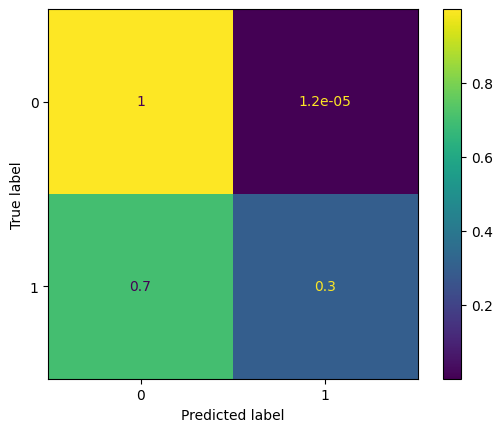

In [130]:
# Confusion matrix
cm = confusion_matrix(y_train, ytrain_pred, normalize = 'true', labels = [0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [0,1])
disp.plot()


Text(0.5, 1.0, 'Precision-Recall Curve of Random Forest')

(-0.1, 1.1)

(-0.1, 1.1)

Text(0, 0.5, 'Precision')

Text(0.5, 0, 'Recall')

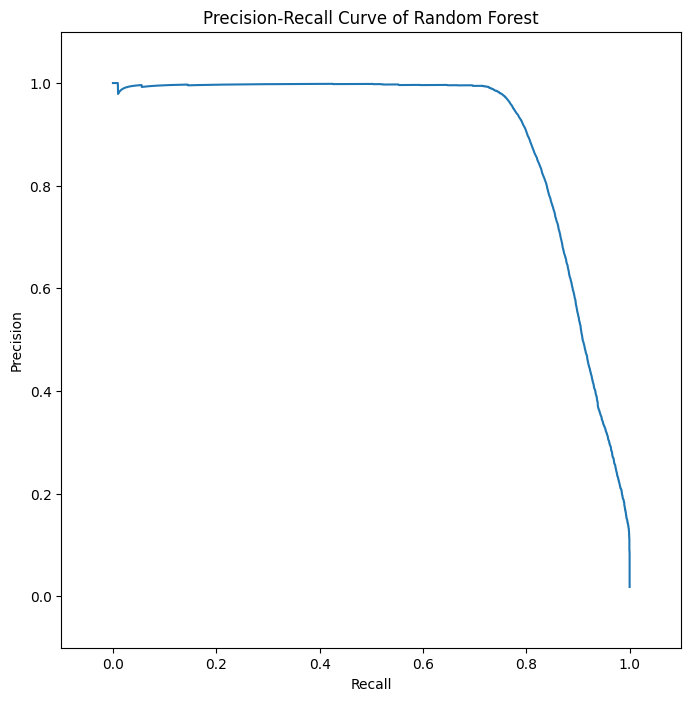

In [117]:
# Plot the Precision Recall curve
y_pred_proba = rf_res['fitted_model'].predict_proba(x_train_pp)[:,1]
precision, recall, thresholds = precision_recall_curve(y_train, y_pred_proba)

fig = plt.figure(figsize=(8,8))
plt.title('Precision-Recall Curve of Random Forest')

plt.plot(recall, precision)

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

### H2o - Random Forest

In [133]:
pip install h2o # # Try H2o random forest

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.3/265.3 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.46.0.4-py2.py3-none-any.whl size=265375576 sha256=4d3a507d6655650171d8465b40b044e8ab56125ffd27987ca990cdad696d2bab
  Stored in directory: /root/.cache/pip/wheels/4d/a6/47/8bfeb1026fd65cb8630beb74d8e3bec844f572cf4f336fdd56
Successfully built h2o


In [139]:
# ref:https://activewizards.com/blog/h2o-framework-for-machine-learning/
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.automl import H2OAutoML #  AutoML is similar to GridSearch but on the level of models rather than on the level of parameters.
from h2o.grid.grid_search import H2OGridSearch

In [162]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.23" 2024-04-16; OpenJDK Runtime Environment (build 11.0.23+9-post-Ubuntu-1ubuntu122.04.1); OpenJDK 64-Bit Server VM (build 11.0.23+9-post-Ubuntu-1ubuntu122.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpcsxufif4
  JVM stdout: /tmp/tmpcsxufif4/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpcsxufif4/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.4
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_unknownUser_1m26s3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [163]:
x_train_h = h2o.H2OFrame(x_train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [177]:
x_test_h = h2o.H2OFrame(x_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [167]:
response = "converted"
x_train_h[response] = x_train_h[response].asfactor()  # set the response as factor
x_train_h[response] = x_train_h[response].asfactor()
predictors = num_vars_m + cat_vars_m

In [172]:
drf_parameters = {
    'max_depth':[10, 20], # default 20
    'min_rows': [1, 10],  # Fewest allowed (weighted) observations in a leaf , default 1.0
    'ntrees':[10, 50, 100] # default 50
}

drf_grid_search = H2OGridSearch(model = H2ORandomForestEstimator,
                                grid_id='drf_grid',
                                hyper_params = drf_parameters)


drf_grid_search.train(x=predictors,
                      y=response,
                      training_frame=x_train_h,
                      nfolds = 3,
                      fold_assignment = 'stratified',
                      # categorical_encoding="auto",  # type: Literal["auto", "enum", "one_hot_internal", "one_hot_explicit", "binary", "eigen", "label_encoder", "sort_by_response", "enum_limited"]
                      seed=0)


drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,max_depth,min_rows,ntrees,model_ids,logloss
,10.0,1.0,100.0,drf_grid_model_9,0.0931343
,10.0,10.0,100.0,drf_grid_model_11,0.0932447
,10.0,1.0,50.0,drf_grid_model_5,0.0934082
,20.0,1.0,100.0,drf_grid_model_10,0.0934204
,10.0,10.0,50.0,drf_grid_model_7,0.0934536
,20.0,10.0,100.0,drf_grid_model_12,0.0935252
,20.0,10.0,50.0,drf_grid_model_8,0.0937655
,20.0,1.0,50.0,drf_grid_model_6,0.0937817
,10.0,1.0,10.0,drf_grid_model_1,0.0946134
,10.0,10.0,10.0,drf_grid_model_3,0.0950390


In [183]:
drf_grid_search.model_performance()

{'drf_grid_model_9': ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.018078234096622108
RMSE: 0.13445532379427044
LogLoss: 0.0923668829286953
Mean Per-Class Error: 0.47222347842477436
AUC: 0.5679057019327423
AUCPR: 0.02341784219916317
Gini: 0.13581140386548451

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.030891282000257755
       0       1      Error    Rate
-----  ------  -----  -------  ------------------
0      223606  24900  0.1002   (24900.0/248506.0)
1      3919    723    0.8442   (3919.0/4642.0)
Total  227525  25623  0.1138   (28819.0/253148.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0308913    0.047778   198
max f2                       0.0175536    0.0967254  277
max f0point5                 0.039557     0.034859   166
max accuracy                 0.386933     0.981659   0
max prec

In [176]:
grid_results = drf_grid_search.get_grid(sort_by='pr_auc', decreasing=True)
grid_results

,max_depth,min_rows,ntrees,model_ids,pr_auc
,20.0,1.0,100.0,drf_grid_model_10,0.0225871
,20.0,1.0,50.0,drf_grid_model_6,0.0223746
,10.0,1.0,100.0,drf_grid_model_9,0.0222560
,10.0,1.0,50.0,drf_grid_model_5,0.0219786
,10.0,10.0,100.0,drf_grid_model_11,0.0219382
,20.0,10.0,100.0,drf_grid_model_12,0.0219201
,10.0,10.0,50.0,drf_grid_model_7,0.0217687
,20.0,10.0,50.0,drf_grid_model_8,0.0217342
,20.0,1.0,10.0,drf_grid_model_2,0.0217199
,10.0,1.0,10.0,drf_grid_model_1,0.0214297


## Testing Performance Evaluation

### Sklearn - Random Forest

In [118]:
# Fit the best model on the entire training dataset
best_model = RandomForestClassifier(random_state = 0,
                                n_estimators = 100, # number of trees in the forest.
                                max_depth = None, # default is None
                                criterion = 'entropy',
                                max_features = 'sqrt',
                                min_samples_split = 2, # default is 2
                                min_samples_leaf = 1, # default is 1
                                ccp_alpha = 1e-05 # pruning parameter， higher value prunes deeper. Tuning doesn't yield a better res
                                )

best_model.fit(x_train_pp, y_train)

RandomForestClassifier(ccp_alpha=1e-05, criterion='entropy', random_state=0)

In [119]:
ytest_pred_proba = best_model.predict_proba(x_test_pp)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, ytest_pred_proba)
test_pr_auc = auc(recall, precision)
test_pr_auc

0.029547956514357158

In [120]:
# precision, recall, specificity, f1-score, geometric mean, and index balanced accuracy of the geometric mean.
ytest_pred = best_model.predict(x_test_pp)
print(classification_report_imbalanced(y_true = y_test, y_pred = ytest_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      1.00      0.00      0.99      0.00      0.00     62127
          1       0.00      0.00      1.00      0.00      0.00      0.00      1160

avg / total       0.96      0.98      0.02      0.97      0.00      0.00     63287



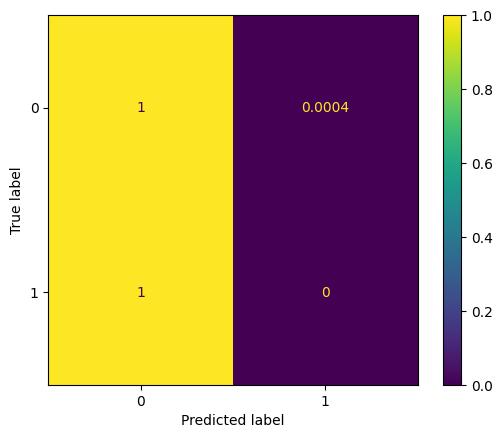

In [121]:
# Confusion matrix
cm = confusion_matrix(y_test, ytest_pred, normalize = 'true', labels = [0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [0,1])
disp.plot()


### H2o - Random Forest

In [184]:
# Grab the best model
best_model = grid_results.models[0]

# Evaluate the model performance on the test set
best_model_test_perf = best_model.model_performance(x_test_h)

best_model_test_perf.aucpr()

0.024937666482075006

## Feature Importance

Both models perform poorly, with a PR AUC of only around 0.02. This is likely due to the lack of important features. Therefore, to conduct more insightful analysis on the key drivers of conversion rates, feature engineering should be a priority in future work.

The feature importances shown below are for illustration purposes only. They don't offer constructive insights due to the model's subpar performance.

<Axes: xlabel='feature_imp', ylabel='feature'>

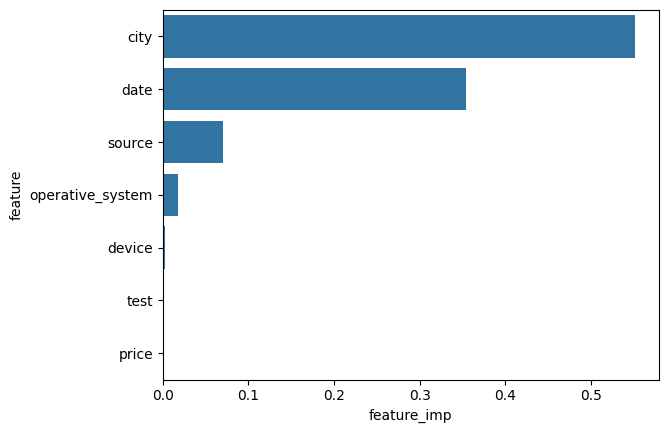

In [131]:
# The feature importance here is Gini importance: (normalized) total reduction of the criterion brought by that feature.
# Since the features are not highly correlated, feature importances can be correctly interpreted.

imp = rf_res['fitted_model'].feature_importances_
imp_df = pd.DataFrame({'feature_imp': imp, 'feature': list(x_train_pp.columns)}).sort_values(by = ['feature_imp'], ascending = False)
sns.barplot(x = imp_df['feature_imp'], y = imp_df['feature'])

In [186]:
# H2o - random forest feature importance
best_model.varimp(use_pandas=True)


,variable,relative_importance,scaled_importance,percentage
0,city,21451.552734,1.000000,0.697714
1,date,4121.901855,0.192149,0.134065
2,source,3160.281006,0.147322,0.102789
3,operative_system,1270.212158,0.059213,0.041314
4,price,424.686401,0.019797,0.013813
5,device,316.833801,0.014770,0.010305


'city' and 'date' are identified as the top important features mainly because they have high number of levels.

## Simple Data Analysis
Since modeling doesn't perform well, we will just conduct simple data analysis below.

In [197]:
for c in cat_vars[:3]:
  data.groupby(c, as_index = False)[['test','converted']].mean().sort_values(by = ['converted'], ascending = False)

,source,test,converted
6,friend_referral,0.365461,0.038688
7,seo-bing,0.380131,0.023787
1,ads-google,0.362256,0.021502
3,ads_facebook,0.361372,0.021198
8,seo-google,0.348194,0.016978
10,seo-yahoo,0.363251,0.016226
11,seo_facebook,0.364538,0.016051
9,seo-other,0.364020,0.015686
2,ads-yahoo,0.364417,0.014793
4,ads_other,0.354389,0.014350


,device,test,converted
0,mobile,0.353782,0.018554
1,web,0.368908,0.018023


,operative_system,test,converted
3,mac,0.347635,0.023987
1,iOS,0.351955,0.022328
5,windows,0.370183,0.016966
0,android,0.356525,0.014919
4,other,0.352105,0.012981
2,linux,0.466344,0.008232


In [200]:
data.groupby('city', as_index = False)[['test','converted']].mean().sort_values(by = ['converted'], ascending = False).head(20)

,city,test,converted
561,North Atlanta,0.800000,0.200000
135,Catonsville,0.384615,0.153846
708,Saint Charles,0.285714,0.142857
611,Parkway-South Sacramento,0.352941,0.117647
280,Findlay,0.666667,0.111111
77,Blue Springs,0.285714,0.095238
81,Bonita Springs,0.636364,0.090909
447,Lehigh Acres,0.413043,0.086957
613,Parsippany-Troy Hills Township,0.270270,0.081081
801,Sun City,0.280899,0.078652


We can see that the top user cohorts that generate high conversion rates are
* source (>2% cvr): friend_referral, seo-bing, ads-google, ads_facebook
* operative_system (>2% cvr): mac, ios
* city (>10% cvr): North Atlanta, Catonsville, Saint Charles, Parkway-South Sacramento, Findlay.

Note that some cohorts, like 'linux', has high 'test' rate, which may contribute to low conversion rate.

# Conclusions

For Q1 and Q3:

Ans. We design the test to detect a significant lift in revenue-per-user after product price increase from \$39 to \$59. Result shows that
* We have run the test LONG ENOUGH to detect a minimum 18% lift in revenue-per-user with at least 80\% power and maximum 5% significance level (false alarm rate).  
* Banking calculation suggests that **by increasing the price from \$39 to \$59, we expect to boost the annual revenue by $191,054**.
* We can also conclude the test as positive by device: there are 22.92\% lift in mobile and 11.86\% lift in web.
* For test granularity by source and city, we need to run the test longer for most of the cases.

For Q2:

Ans. Due to the lack of important features, we are unable to build a ML model with good performance. Thus, the conclusion below are based on simple data analysis.

The top user cohorts that generate high conversion rates are
* source (>2% cvr): friend_referral, seo-bing, ads-google, ads_facebook
* operative_system (>2% cvr): mac, ios
* city (>10% cvr): North Atlanta, Catonsville, Saint Charles, Parkway-South Sacramento, Findlay.

Note that some small cohorts, e.g. 'linux', are not balanced well in terms of the test assignment. Thus, their low conversion rate might be due to high 'test' rate.

To further prove the analysis results above, we can design and conduct AB testing on conversion rate v.s. user cohorts.

# Future Work
* There was a spike in the revenue-per-user of the treatment group on 5/27/2015 and 5/28/2015. 5/25/2015 was the Memorial Day, and this might be the reason. We need to investigate further.
* Run the test longer according to the sample size calculation result. After the required sample size has reached, run the test again.
* If necessary, we can search for the margin information in the database, so that we are able to conduct AB test on the profit.
* To find out the key drivers of conversion rate, we can either
  * Conduct feature engineeing the boost the ML model performance.
  * Or design and conduct AB testing on various user cohorts.
* Develop a pricing optimization algorithm to find the optimal price instead of conducting AB testing only on one alternative price point, which is both time-consuming and resource-consuming.